In [1]:
import tensorflow as tf
import numpy as np
%config Completer.use_jedi = False
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split
import random
# %config IPCompleter.greedy=True

In [2]:
df=pd.read_csv('spam.csv',error_bad_lines=False,encoding= 'Windows-1252')
X=df['v2']
y=df['v1'].apply(lambda x:0 if x=='spam' else 1)
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.25)

num_words=None
embedding_length=20
tok=Tokenizer(num_words=num_words)
tok.fit_on_texts(X_train)
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
X_train=pad_sequences(X_train)
X_test=pad_sequences(X_test,maxlen=X_train.shape[1])
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

maxsequencelength=X_train.shape[1]
input_dim=num_words if num_words else (max(tok.word_index.values())+1)

inputlayer=tf.keras.layers.Input(shape=[maxsequencelength,])
x=tf.keras.layers.Embedding(input_dim=input_dim,output_dim=embedding_length,input_length=maxsequencelength)(inputlayer)
x=tf.keras.layers.Conv1D(16,3,activation='relu')(x)
x=tf.keras.layers.MaxPooling1D(3)(x)
x=tf.keras.layers.Conv1D(32,3,activation='relu')(x)
x=tf.keras.layers.MaxPooling1D(3)(x)
x=tf.keras.layers.Conv1D(64,3,activation='relu')(x)
x=tf.keras.layers.GlobalMaxPooling1D()(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x)

mymodel=tf.keras.Model(inputs=inputlayer,outputs=x)
mymodel.summary()

mymodel.compile(loss='binary_crossentropy',metrics=['accuracy'])
r = mymodel.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 189, 20)           155620    
_________________________________________________________________
conv1d (Conv1D)              (None, 187, 16)           976       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 64)            6208  

In [2]:
df=pd.read_csv('spam.csv',error_bad_lines=False,encoding= 'Windows-1252')
text=list(df['v2'].values)

def get_augmented_text(text):
    newtextlist=[]
    for eachtext in text:
        char_to_replace=random.choice('abcdefghijklmnopqrstuvwxyz')
        replace_char_with=random.choice('abcdefghijklmnopqrstuvwxyz')
        newtext=eachtext.replace(char_to_replace,replace_char_with)
        newtextlist.append([[eachtext,newtext],0])
    return newtextlist

def get_neg_samples(text):
    negsamplelist=[]
    for _ in range(5):
        for i,eachtext in enumerate(text):
            negsample=random.choice(text)
            while eachtext == negsample:
                negsample=random.choice(text)
            negsamplelist.append([[eachtext,negsample],1])
    return negsamplelist

augmentedtext=get_augmented_text(text)
negsamplestext=get_neg_samples(text)
X1=[]
X2=[]
y=[]
alltrainingsamples=augmentedtext+negsamplestext
random.shuffle(alltrainingsamples)
for sample in alltrainingsamples:
    X1.append(sample[0][0])
    X2.append(sample[0][1])
    y.append(sample[1])

In [3]:
embedding_length=100
maxsequencelength=100

tok=tf.keras.preprocessing.text.Tokenizer(char_level=True)

tok.fit_on_texts(X1 + X2)
X1=tok.texts_to_sequences(X1)
X2=tok.texts_to_sequences(X2)
X1=tf.keras.preprocessing.sequence.pad_sequences(X1,maxlen=maxsequencelength)
X2=tf.keras.preprocessing.sequence.pad_sequences(X2,maxlen=maxsequencelength)
input_dim=max(tok.word_index.values())+1

def get_feature_map(inputlayer):
    x=tf.keras.layers.Embedding(input_dim=input_dim,output_dim=embedding_length,input_length=maxsequencelength)(inputlayer)
    x=tf.keras.layers.Conv1D(16,5,activation='relu')(x)
    x=tf.keras.layers.MaxPooling1D(3)(x)
    x=tf.keras.layers.Conv1D(32,3,activation='relu')(x)
    x=tf.keras.layers.MaxPooling1D(3)(x)
    x=tf.keras.layers.Conv1D(64,3,activation='relu')(x)
    featuremap=tf.keras.layers.GlobalMaxPooling1D()(x)
    return featuremap


inputlayer1=tf.keras.layers.Input(shape=[maxsequencelength,])
featuremap1=get_feature_map(inputlayer1)
inputlayer2=tf.keras.layers.Input(shape=[maxsequencelength,])
featuremap2=get_feature_map(inputlayer2)
difference=featuremap1 - featuremap2
output=tf.keras.layers.Dense(1,activation='sigmoid')(difference)
mymodel=tf.keras.Model(inputs=[inputlayer1,inputlayer2],outputs=output)

mymodel.compile(loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(),'accuracy'])
r = mymodel.fit([X1,X2], np.array(y), epochs=1,validation_split=0.2)

836/836 [==============================] - 21s 22ms/step - loss: 0.4541 - auc: 0.4873 - accuracy: 0.8345 - val_loss: 0.4583 - val_auc: 0.4956 - val_accuracy: 0.8288


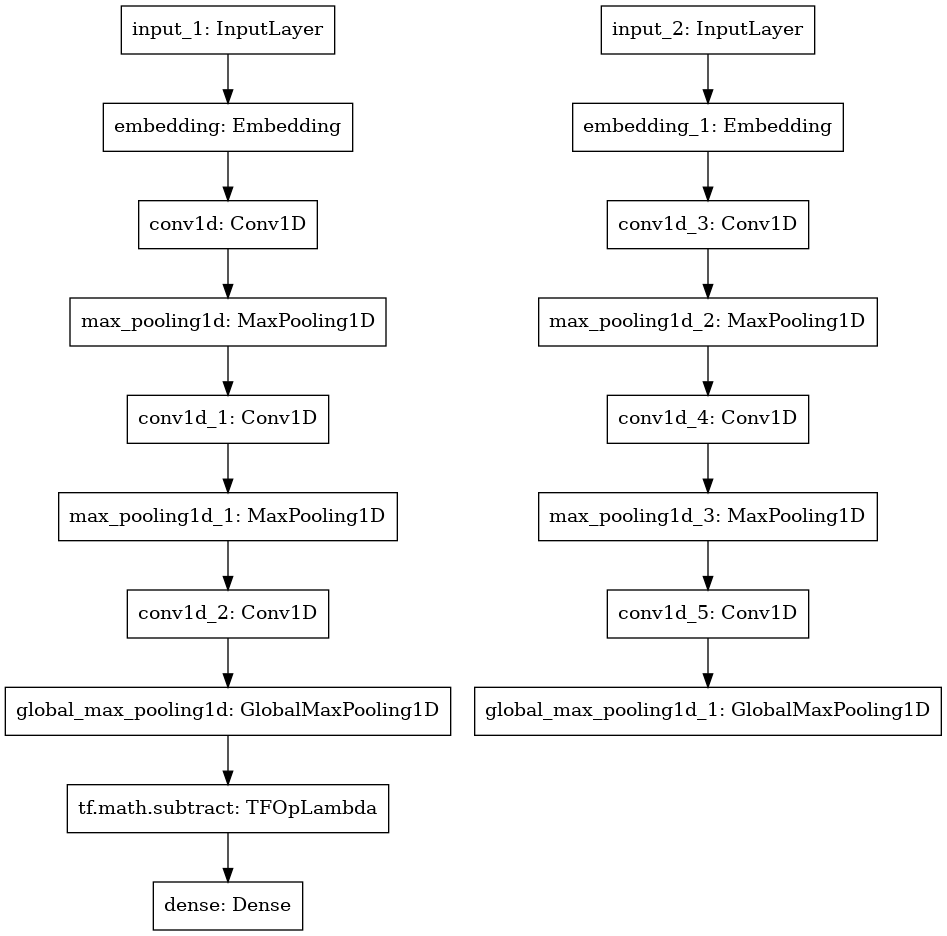

In [4]:
tf.keras.utils.plot_model(mymodel)

In [38]:
predictme=text[0]

In [43]:
tok.texts_to_sequences([predictme])

[[19,
  3,
  1,
  12,
  7,
  4,
  6,
  10,
  1,
  36,
  12,
  9,
  3,
  7,
  19,
  1,
  20,
  3,
  6,
  7,
  4,
  26,
  1,
  17,
  9,
  5,
  45,
  16,
  14,
  14,
  1,
  5,
  24,
  5,
  6,
  10,
  5,
  22,
  10,
  2,
  1,
  3,
  7,
  10,
  16,
  1,
  6,
  7,
  1,
  22,
  12,
  19,
  6,
  8,
  1,
  7,
  1,
  19,
  9,
  2,
  5,
  4,
  1,
  18,
  3,
  9,
  10,
  13,
  1,
  10,
  5,
  1,
  2,
  1,
  22,
  12,
  21,
  21,
  2,
  4,
  14,
  14,
  14,
  1,
  17,
  6,
  7,
  2,
  1,
  4,
  11,
  2,
  9,
  2,
  1,
  19,
  3,
  4,
  1,
  5,
  15,
  3,
  9,
  2,
  1,
  18,
  5,
  4,
  14,
  14,
  14]]

In [45]:
tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength)

array([[ 9,  3,  7, 19,  1, 20,  3,  6,  7,  4, 26,  1, 17,  9,  5, 45,
        16, 14, 14,  1,  5, 24,  5,  6, 10,  5, 22, 10,  2,  1,  3,  7,
        10, 16,  1,  6,  7,  1, 22, 12, 19,  6,  8,  1,  7,  1, 19,  9,
         2,  5,  4,  1, 18,  3,  9, 10, 13,  1, 10,  5,  1,  2,  1, 22,
        12, 21, 21,  2,  4, 14, 14, 14,  1, 17,  6,  7,  2,  1,  4, 11,
         2,  9,  2,  1, 19,  3,  4,  1,  5, 15,  3,  9,  2,  1, 18,  5,
         4, 14, 14, 14]], dtype=int32)

In [70]:
mymodel.predict(
   [ tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength),
    tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength)]
)

array([[0.89613146]], dtype=float32)

In [50]:
mymodel.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 100, 100)     9200        input_12[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 100, 100)     9200        input_13[0][0]                   
____________________________________________________________________________________________

In [60]:
for i,layer in enumerate(mymodel.layers):
    print(i,layer.name)

0 input_12
1 input_13
2 embedding_11
3 embedding_12
4 conv1d_33
5 conv1d_36
6 max_pooling1d_22
7 max_pooling1d_24
8 conv1d_34
9 conv1d_37
10 max_pooling1d_23
11 max_pooling1d_25
12 conv1d_35
13 conv1d_38
14 global_max_pooling1d_11
15 global_max_pooling1d_12
16 tf.math.subtract_5
17 dense_6


In [71]:
mynewmodel=tf.keras.Model(inputs=mymodel.input,outputs=mymodel.layers[-4].output)

In [72]:
mynewmodel.predict(
 [ tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength),
    tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength)]
)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.18673281,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 16.33448   ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.855888  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [73]:
mynewmodel2=tf.keras.Model(inputs=mymodel.input,outputs=mymodel.layers[-3].output)

In [74]:
mynewmodel2.predict(
 [ tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength),
    tf.keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences([predictme]),maxlen=maxsequencelength)]
)

array([[1.2148689 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.5052018 , 0.        ,
        0.        , 0.        , 1.3258188 , 0.        , 0.        ,
        0.20750208, 0.        , 0.        , 0.35692635, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.4527096 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.16306864,
        0.        , 0.        , 0.        , 0.        , 2.132071  ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 2.743058  , 0.        , 0.        , 0.        ,
        0.        , 0.7688881 , 0.        , 0.        , 1.8490735 ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)